In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 21g

##  Convolutional Neural Network (CNN)
- Fashion MNIST
- Dataset From CSV File
- Batch Norm
- Dropout
- Early Stopping
- Learning Rate Decay
- Model Saving

<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
#import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report

import tensorflow as tf

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

2024-07-25 18:44:43.186057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 18:44:43.199060: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 18:44:43.202840: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-25 18:44:43.213411: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-25 18:44:44.014366: W tensorflow/compiler/tf2

In [3]:
###----------------------
### Some basic parameters
###----------------------


inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs
modelDir = '../models'
subDir = 'fashion_mnist'
altName = 'mnist_cnn'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well

ALPHA = 0.001

EPOCHS = 200 # number of cycles to run


BATCH_SIZE = 64 # inline of Training Rows being 60000

ES_PATIENCE = 10

LR_PATIENCE = 10
LR_FACTOR = 0.1

# Set parameters for decoration of plots
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

## Basic Hygiene

In [4]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    
print (physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1721913284.713776   33471 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721913284.751770   33471 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721913284.755952   33471 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


## Using MNIST Fashion data

### Labels

Total : 785 columns
First column is label remaining columns are pixel values of the images.

Each training and test example is assigned to one of the following labels:


|Label| Class
|:-|:-|
0 | T-shirt/top
1 | Trouser
2 | Pullover
3 | Dress
4 | Coat
5 | Sandal
6 | Shirt
7 | Sneaker
8 | Bag
9 | Ankle boot

In [5]:
class_labels ={0 : 'T-shirt/top',
               1 : 'Trouser',
               2 : 'Pullover',
               3 : 'Dress',
               4 : 'Coat',
               5 : 'Sandal',
               6 : 'Shirt',
               7 : 'Sneaker',
               8 : 'Bag',
               9 : 'Ankle boot'
              }

In [6]:
train_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_train.csv')
test_filename = os.path.join(inpDir, 'fashion_mnist', 'fashion-mnist_test.csv')

train_df = pd.read_csv(train_filename, header = 0)
test_df = pd.read_csv(test_filename, header = 0)

In [7]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Converting to Datasets

In [9]:
# Each row need to be seperated in features and labels
def split_feature_label(row ):
    '''
    Args:
        row: array of 785 values
    returns:
        feature : np.ndarray of shape (28 x 28, 1)
        label: integer
    '''
    
    feature = tf.reshape(row[1:], [28, 28, 1])
    
    label = row[0]
    
    return feature, label

In [10]:
# Create training dataset
tmp_ds = tf.data.Dataset.from_tensor_slices(train_df)

train_ds = tmp_ds.map(split_feature_label)

train_ds = train_ds.batch(BATCH_SIZE)

tmp_ds = tf.data.Dataset.from_tensor_slices(test_df)

test_ds = tmp_ds.map(split_feature_label)

test_ds = test_ds.batch(BATCH_SIZE)

I0000 00:00:1721913286.797704   33471 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721913286.801996   33471 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721913286.805767   33471 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1721913286.937699   33471 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image.


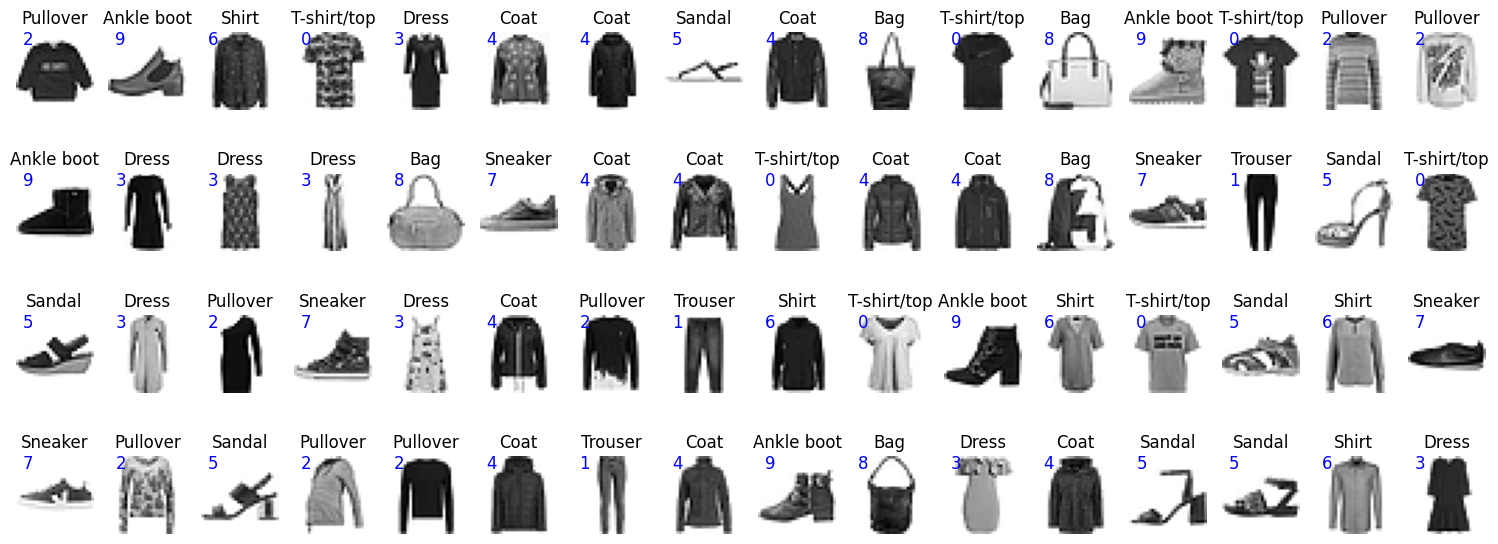

2024-07-25 18:44:49.708062: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
for images, labels in train_ds.take(1): # gets a batch of first BATCH_SIZE images
    
    for i in range(BATCH_SIZE):
        
        plt.subplot(4,int(BATCH_SIZE/4),i+1)
        
        plt.grid(False)
        
        plt.imshow(images[i].numpy().astype("uint8"), cmap=plt.cm.binary)
        
        plt.title(class_labels[labels[i].numpy()])
        
        plt.text(2, 4, labels[i].numpy(), color='b', fontsize=12)
        
        plt.axis("off")
    
    plt.tight_layout()
    
    plt.show()

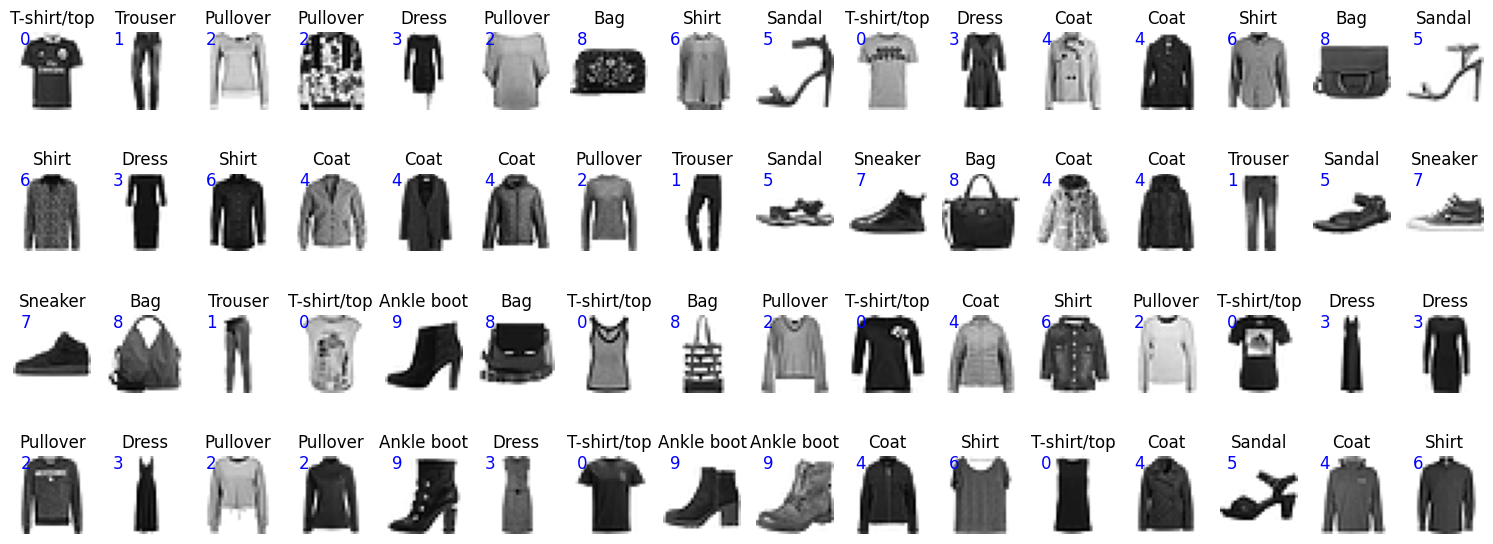

2024-07-25 18:44:51.633291: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
for images, labels in test_ds.take(1): # gets a batch of first BATCH_SIZE images
    
    for i in range(BATCH_SIZE):
        
        plt.subplot(4,int(BATCH_SIZE/4),i+1)
        
        plt.grid(False)
        
        plt.imshow(images[i].numpy().astype("uint8"), cmap=plt.cm.binary)
        
        plt.title(class_labels[labels[i].numpy()])
        
        plt.text(2, 4, labels[i].numpy(), color='b', fontsize=12)
        
        plt.axis("off")
    
    plt.tight_layout()
    
    plt.show()

In [13]:
## Optimize for performance

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

### Create the Convolution base

<img src = '../../images/dnn_nb_cnn_MNIST.png' style = 'width:800px;' alt="Demo Convolution Network MNIST" align="left">

In [14]:
def build_model(input_shape: tuple, num_classes: int):
    
    krnl_init = tf.keras.initializers.GlorotUniform( seed = RANDOM_STATE)

    dor1 = 0.1
    dor2 = 0.2
    dor3 = 0.5
    dor4 = 0.5

    # create a sequential model
    model = tf.keras.models.Sequential()

    # create input layer
    model.add(tf.keras.layers.Input(shape=input_shape))

    model.add( tf.keras.layers.Rescaling(1./255) )
    ###------
    ### Set 1
    ###------
    # Convolution 1
    model.add(tf.keras.layers.Conv2D(64, (3, 3),
                                     kernel_initializer = krnl_init,
                                     padding='same',
                                     use_bias=False))   # 28 x 28 x 64

    # Batch Normalization 1
    model.add(tf.keras.layers.BatchNormalization())

    # Activation 1
    model.add(tf.keras.layers.ReLU())
    #model.add(tf.keras.layers.Activation(activation='swish'))

    # Dropout 1
    #model.add(tf.keras.layers.Dropout(dor1))

    # Pool 1
    model.add(tf.keras.layers.MaxPooling2D((2, 2))) # 14 x 14 x 64
    
    ###------
    ### Set 2
    ###------
    # Convolution 2
    model.add(tf.keras.layers.Conv2D(128, (3, 3),
                                     use_bias=False,
                                     kernel_initializer = krnl_init)) # 12 x 12 x 128
    # Batch Normalization 2
    model.add(tf.keras.layers.BatchNormalization())

    # Activation 2
    model.add(tf.keras.layers.ReLU())
    #model.add(tf.keras.layers.Activation(activation='swish'))

    # Dropout 2
    model.add(tf.keras.layers.Dropout(dor2))

    # Pool 2
    model.add(tf.keras.layers.MaxPooling2D((2, 2))) # 6 x 6 X 128
    
    ###------
    ### Set 3
    ###------
    # Convolution 3
    model.add(tf.keras.layers.Conv2D(256, (3, 3),
                                     use_bias=False,
                                     kernel_initializer = krnl_init) )    # 4 x 4 x 256
    
    # Batch Normalization 3
    model.add(tf.keras.layers.BatchNormalization())
    
    # Activation 3
    model.add(tf.keras.layers.ReLU())
    #model.add(tf.keras.layers.Activation(activation='swish'))

    # Dropout 3
    model.add(tf.keras.layers.Dropout(dor3))

    ###-----
    ### Head
    ###-----
    model.add(tf.keras.layers.Flatten())

    # Dense 1
    model.add(tf.keras.layers.Dense(256,
                                    use_bias=False,
                                    kernel_initializer = krnl_init))
    # Batch Normalization 4
    model.add(tf.keras.layers.BatchNormalization())

    # Activation 4
    model.add(tf.keras.layers.ReLU())
    #model.add(tf.keras.layers.Activation(activation='swish'))

    # Dropout 4
    model.add(tf.keras.layers.Dropout(dor4))

    # Dense 2
    model.add(tf.keras.layers.Dense(num_classes, kernel_initializer = krnl_init))
    
    return model

In [15]:
input_shape=(28, 28, 1)

num_classes = 10

# build a sequential model
model = build_model(input_shape, num_classes)

# Directory where the checkpoints will be saved
checkpoint_dir = os.path.join(modelDir, subDir)

# Early Stopping
early_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True, # keeps the best weights only
    patience=ES_PATIENCE,
    verbose=1)


# Reduction schedule for alpha
# Where is Alpha specified?
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=LR_FACTOR,
    patience=LR_PATIENCE,
    verbose=1)

checkpoint_prefix = os.path.join(checkpoint_dir, f'{altName}.keras')

# Save weights
model_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    monitor='val_loss',
    mode='auto',
    save_best_only=True,
    verbose=1)

### Compile and train the model

In [16]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=ALPHA),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=[early_callback, lr_reduce, model_callback],
    validation_data=test_ds,
    verbose = 2)

Epoch 1/200


I0000 00:00:1721913293.275584   33567 service.cc:146] XLA service 0x7745ec013130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721913293.275630   33567 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-07-25 18:44:53.327140: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-25 18:44:53.562101: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
I0000 00:00:1721913296.969107   33567 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.



Epoch 1: val_loss improved from inf to 0.28922, saving model to ../models/fashion_mnist/mnist_cnn.keras
938/938 - 14s - 14ms/step - accuracy: 0.8414 - loss: 0.4444 - val_accuracy: 0.8962 - val_loss: 0.2892 - learning_rate: 0.0010
Epoch 2/200

Epoch 2: val_loss improved from 0.28922 to 0.24459, saving model to ../models/fashion_mnist/mnist_cnn.keras
938/938 - 4s - 4ms/step - accuracy: 0.8909 - loss: 0.3036 - val_accuracy: 0.9130 - val_loss: 0.2446 - learning_rate: 0.0010
Epoch 3/200

Epoch 3: val_loss improved from 0.24459 to 0.23907, saving model to ../models/fashion_mnist/mnist_cnn.keras
938/938 - 4s - 4ms/step - accuracy: 0.9033 - loss: 0.2670 - val_accuracy: 0.9108 - val_loss: 0.2391 - learning_rate: 0.0010
Epoch 4/200

Epoch 4: val_loss improved from 0.23907 to 0.23733, saving model to ../models/fashion_mnist/mnist_cnn.keras
938/938 - 4s - 4ms/step - accuracy: 0.9121 - loss: 0.2404 - val_accuracy: 0.9159 - val_loss: 0.2373 - learning_rate: 0.0010
Epoch 5/200

Epoch 5: val_loss did

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 12, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 256)      │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,266,720 (16.28 MB)

 Trainable params: 1,421,770 (5.42 MB)

 Non-trainable params: 1,408 (5.50 KB)

 Optimizer params: 2,843,542 (10.85 MB)

In [18]:
res_df = pd.DataFrame(history.history)
res_df.head()

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.841383,0.444371,0.8962,0.289223,0.001
1,0.890867,0.303638,0.9130,0.244586,0.001
2,0.903333,0.266979,0.9108,0.239066,0.001
3,0.912100,0.240408,0.9159,0.237333,0.001
4,0.919800,0.220923,0.9087,0.239492,0.001


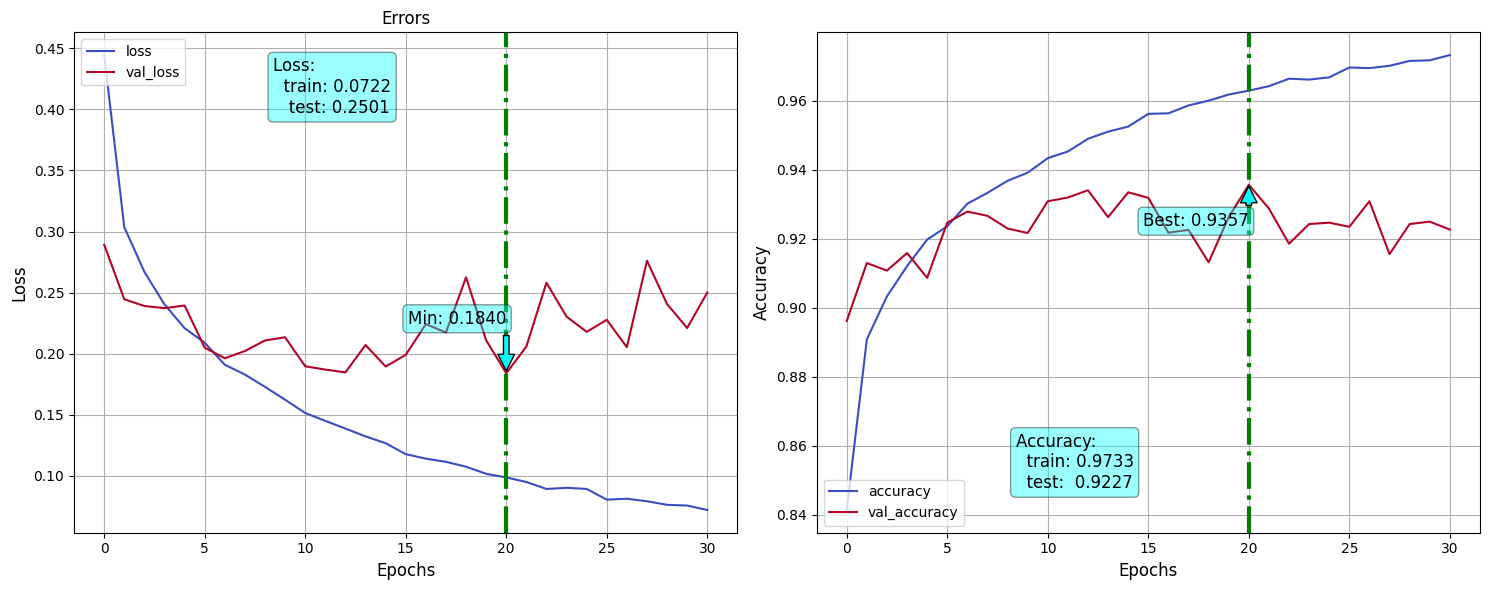

In [19]:
fn_plot_tf_hist(res_df)

### Evaluate the model

In [20]:
test_loss, test_acc = model.evaluate(test_ds, verbose=2)

157/157 - 0s - 1ms/step - accuracy: 0.9357 - loss: 0.1840


In [21]:
#yhat = model.predict(X_test, batch_size=n_batch)
yhat = model.predict(test_ds)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [22]:
y_test = tf.concat([y for x, y in test_ds], axis=0).numpy()

In [23]:
y_pred = yhat.argmax(axis = 1)

print('Accuracy score on Test Data :', accuracy_score(y_test, y_pred))

Accuracy score on Test Data : 0.9357


In [24]:
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1000
           1       0.99      0.99      0.99      1000
           2       0.93      0.88      0.91      1000
           3       0.94      0.95      0.94      1000
           4       0.88      0.93      0.90      1000
           5       0.99      0.98      0.99      1000
           6       0.82      0.81      0.81      1000
           7       0.97      0.95      0.96      1000
           8       1.00      0.98      0.99      1000
           9       0.95      0.99      0.97      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



In [25]:
test_df['y_pred'] = y_pred

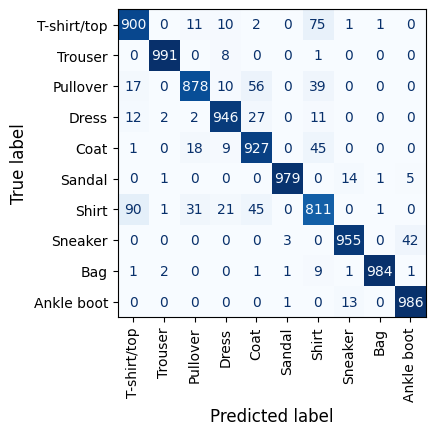

In [26]:
fn_plot_confusion_matrix(y_test, y_pred, class_labels)

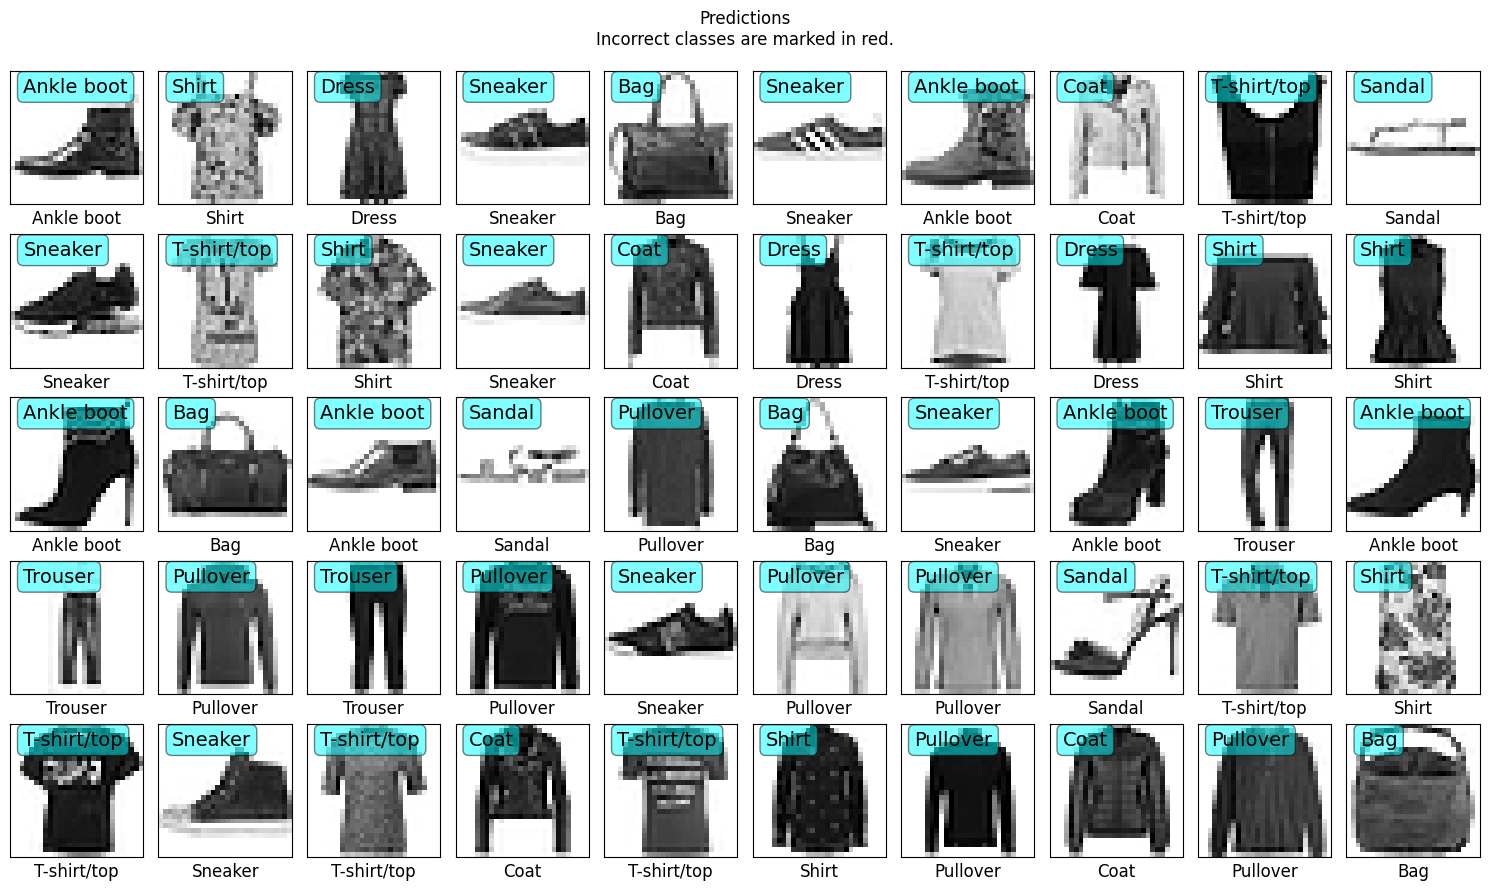

In [27]:
# Results data plot

plot_df = test_df.sample(n = 50) # Take 50 sample from the training set

fig = plt.figure(figsize=(15, 9))  # figure size in inches

fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # adjust subplots

i = 0

fntsize = 12

for _, row in plot_df.iterrows(): # iterate through all rows of the dataframe
    
    i = i + 1
    
    image = row.values[1:-1].reshape(28,28) # reshape row to a 28x28 matrix
    
    if row.iloc[0]!= row.iloc[-1]:
        color = 'red'
    else:
        color = 'cyan'
        
    props = dict(boxstyle='round', facecolor=color, alpha=0.5)
    
    ax = fig.add_subplot(5, 10, (i), xticks=[], yticks=[]) # add a subplot to the figure
    
    ax.imshow(image, cmap=plt.cm.binary, interpolation='nearest') # show image on the axis
    
    ax.set_xlabel(class_labels[row.iloc[0]], fontsize=fntsize)   # add number (class) of the image
    
    ax.text(0.1, 0.95, class_labels[row.iloc[-1]], transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)   # add number (class) of the image
    
fig.suptitle('Predictions\nIncorrect classes are marked in red.')
plt.tight_layout()
plt.show()